In [63]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,path,target_column,drop_cols, p_lag=0, test=False):
        self.df = pd.read_csv(path)
        self.df = self.df.drop(drop_cols, axis=1)
        if test: 
            self.df = self.df.iloc[round(len(self.df)*0.8):len(self.df),:]
        else: 
            self.df = self.df.iloc[0:round(len(self.df)*0.8),:]
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag 
        self.target_column = target_column
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().reshape(1,-1), requires_grad=True)
        input = input_p_lag.reshape(-1)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag + 1),:].astype(float).to_numpy()).reshape([])
        return input, target

In [78]:
import math
import torch.nn as nn
from torch.nn.functional import normalize

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features):
        super(ARNet, self).__init__()
        self.input_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_layer = nn.Linear(math.ceil(p_lag * n_features/2), 1)
        self.criterion = nn.MSELoss()

    def forward(self, input):
        input = input.float()
        input = normalize(input)
        input = self.input_layer(input)
        return torch.exp(self.output_layer(input))

In [88]:
net = ARNet(2, 7)
net(torch.tensor([[41.1300, 12.4810, 36.5360,  9.3550,  4.4240,  1.3110, 38.6620, 39.6220,
         11.3090, 35.5440,  8.5510,  3.2090,  1.2580, 38.2230]],
       dtype=torch.float64))

tensor([[0.9183]], grad_fn=<ExpBackward0>)

In [96]:
from torch.utils.data import DataLoader

p_lag = 2

net = ARNet(p_lag, 7)

train_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv',target_column = ['OT'],drop_cols='date',p_lag=p_lag,test=False))
train_loss_list = []
test_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv',target_column = ['OT'],drop_cols='date',p_lag=p_lag,test=True))
test_loss_list = []

torch.set_grad_enabled(True)
optimizer = torch.optim.Adam(net.parameters(), lr=1.e-6)
running_train_loss = 0.
running_test_loss = 0.
train_counter = 1
test_counter = 1
for epoch in range(1): 
    for i, data in enumerate(train_data):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(torch.log(inputs))
        print(outputs)
        #for name, param in net.named_parameters():
        #    if param.requires_grad:
        #        print(name, param.data)
        loss = net.criterion(outputs, labels.unsqueeze(0).float())
        print(loss.grad)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.1)
        optimizer.step()
        running_train_loss += loss.item()
        train_counter += 1
        if train_counter % 100 == 0: 
            print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

    train_loss_list.append(running_train_loss/train_counter)
        

    for i, data in enumerate(test_data):
        inputs, test_labels = data
        output = net(torch.log(inputs))
        test_loss = net.criterion(output, test_labels.unsqueeze(0).float())
        running_test_loss += test_loss.item()
        test_counter += 1
    test_loss_list.append(running_test_loss/test_counter)

    if epoch % 1 == 0: 
        print(f"Epoch {epoch}: ")
        print(f"Running (training) loss is {running_train_loss/train_counter}.")
        print(f"Test loss is {running_test_loss/test_counter}.")
        print("---------------------------")

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(torch.log(inputs))
    print(f"predicted output is {output.item()} and true value is {labels.item()}")


tensor([[0.8513]], grad_fn=<ExpBackward0>)
tensor([[0.8551]], grad_fn=<ExpBackward0>)
tensor([[0.8524]], grad_fn=<ExpBackward0>)
tensor([[0.8526]], grad_fn=<ExpBackward0>)
tensor([[0.8519]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<ExpBackward0>)
tensor([[nan]], grad_fn=<

KeyboardInterrupt: 

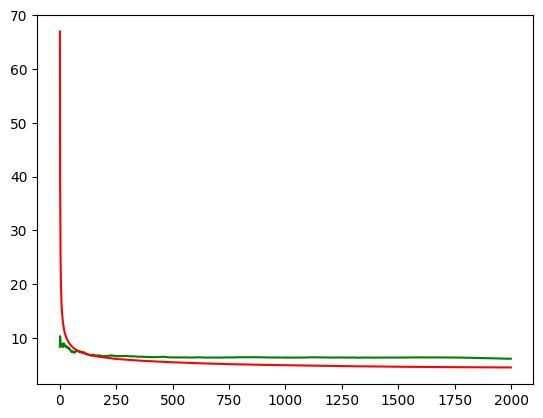

In [290]:
import matplotlib.pyplot as plt
plt.plot(test_loss_list, 'g', train_loss_list, 'r')
plt.show()